# Gender classification

## Libraries

In [235]:
import tarfile
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import opensmile
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchinfo import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Default Device

In [2]:
if torch.cuda.is_available(): print(torch.cuda.get_device_name())
else: print('cpu')
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

NVIDIA GeForce GTX 1660 Ti


## Extract .tar.gz file

In [3]:
input_tar_gz_file  = 'cv-corpus-12.0-delta-2022-12-07-en.tar.gz'
output_dir  = 'extracted_files'

In [4]:
# Create the output folder if it doesn't exist
os.makedirs(output_dir , exist_ok=True)

In [5]:
# Open the .tar.gz file
with tarfile.open(input_tar_gz_file, 'r:gz') as tar:
    tar.extractall(path=output_dir)

## Open Dataset

In [6]:
df = pd.read_csv('./extracted_files/cv-corpus-12.0-delta-2022-12-07/en/other.tsv', sep='\t')
df = df[df['gender'].isin(['male', 'female'])]
filtered_df = df[['path', 'gender']]
filtered_df.loc[:, 'gender'] = filtered_df['gender'].map({'male': 1, 'female': 0})

## Add gaussian noise for data augmentation

In [7]:
def add_gaussian_noise(signal, noise_level=0.005):
    """Add Gaussian noise to the signal"""
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

In [8]:
sound_dir = './extracted_files/cv-corpus-12.0-delta-2022-12-07/en/clips'

In [12]:
for index, row in filtered_df[filtered_df['gender'] == 0].iterrows():
    
    waveform, sr = librosa.load(f'{sound_dir}/{row['path']}')
    noisy = add_gaussian_noise(waveform)

    sf.write(f'{sound_dir}/noisy_{row['path'].split('.')[0]}.wav', noisy, sr)

    new_row = pd.DataFrame({'path': [f'noisy_{row['path'].split('.')[0]}.wav'], 'gender': [0]})

    filtered_df = pd.concat([filtered_df, new_row], ignore_index=True)

In [13]:
filtered_df['gender'].value_counts()

gender
1    16911
0    11136
Name: count, dtype: int64

## Feature extraction

In [17]:
paths, labels = np.array(filtered_df['path']), np.array(filtered_df['gender'])

In [19]:
target_sr = 16000

smile = opensmile.Smile(feature_set=opensmile.FeatureSet.emobase,
                        feature_level=opensmile.FeatureLevel.Functionals,
                        sampling_rate=target_sr)

In [83]:
for index, row in filtered_df.iterrows():

    waveform, _ = librosa.load(f'{sound_dir}/{row['path']}')
    waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
    
    features = smile(waveform, target_sr).reshape([len(smile.feature_names),])

    if index == 0: 
        features_df = pd.DataFrame([list(features) + [row['gender']]], columns=smile.feature_names + ['gender'])
    else:
        new_row = pd.DataFrame([list(features) + [row['gender']]], columns=smile.feature_names + ['gender'])
        features_df = pd.concat([features_df, new_row], ignore_index=True)

In [100]:
features_df['gender'].value_counts()

gender
1    16911
0    11136
Name: count, dtype: int64

In [101]:
features_df.to_csv('features_df.csv', index=False)

In [104]:
features_df = pd.read_csv('features_df.csv')

## Normalization

In [107]:
features = np.array(features_df.drop(columns='gender'))
labels = np.array(features_df['gender'])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    shuffle=True,
                                                    stratify=labels)

In [117]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [236]:
joblib.dump(scaler, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

In [237]:
scaler = joblib.load('minmax_scaler.pkl')

## Dataloader

In [184]:
class CustomLoader(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        Y = self.labels[index]
        return X.astype(np.float32), Y

In [185]:
batch_size = 64
train_set = CustomLoader(features=X_train, labels=y_train)
valid_set = CustomLoader(features=X_test, labels=y_test)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

## Dataloader for unseen data

In [357]:
# class CustomLoader(Dataset):
    
#     def __init__(self, paths, labels, data_dir, target_sr):
#         self.paths = paths
#         self.labels = labels
#         self.dir = data_dir
#         self.target_sr = target_sr
#         self.smile = opensmile.Smile(feature_set=opensmile.FeatureSet.emobase,
#                                      feature_level=opensmile.FeatureLevel.Functionals,
#                                      sampling_rate=target_sr)

#     def __len__(self):
#         return len(self.paths)
    
#     def __getitem__(self, index) :

#         waveform, sr = librosa.load(f'{self.dir}/{self.paths[index]}')
#         waveform = librosa.resample(waveform, orig_sr=sr, target_sr=self.target_sr)

#         wave = self.smile(waveform, self.target_sr).reshape([len(self.smile.feature_names),])
#         label = self.labels[index]

#         return wave, label

In [361]:
# X_train, X_test, y_train, y_test = train_test_split(paths, 
#                                                     labels, 
#                                                     test_size=0.2, 
#                                                     shuffle=True,
#                                                     stratify=labels)

In [362]:
# batch_size = 64
# target_sr = 16000
# train_set = CustomLoader(paths=X_train, labels=y_train, data_dir=sound_dir, target_sr=target_sr)
# valid_set = CustomLoader(paths=X_test, labels=y_test, data_dir=sound_dir, target_sr=target_sr)
# train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(dataset=valid_set, batch_size=batch_size, shuffle=True)

## Model

In [203]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=988, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=32)
        self.fc6 = nn.Linear(in_features=32, out_features=2)
        self.softmax = nn.Softmax(dim=-1) # For binary classification
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        x = self.relu(x)
        x = self.fc6(x)
        x = self.softmax(x)
        return x

In [204]:
mlp = MLP().to(default_device)

In [205]:
summary(mlp, [batch_size, 988])

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [64, 2]                   --
├─Linear: 1-1                            [64, 512]                 506,368
├─ReLU: 1-2                              [64, 512]                 --
├─Linear: 1-3                            [64, 256]                 131,328
├─ReLU: 1-4                              [64, 256]                 --
├─Linear: 1-5                            [64, 128]                 32,896
├─ReLU: 1-6                              [64, 128]                 --
├─Linear: 1-7                            [64, 64]                  8,256
├─ReLU: 1-8                              [64, 64]                  --
├─Linear: 1-9                            [64, 32]                  2,080
├─ReLU: 1-10                             [64, 32]                  --
├─Linear: 1-11                           [64, 2]                   66
├─Softmax: 1-12                          [64, 2]                 

## training

In [206]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.0005
weight_decay = 0.001

# loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=learning_rate, weight_decay=weight_decay)

history = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
min_loss = 1e9

In [207]:
for epoch in range(num_epochs):

    # training
    mlp.train()
    steps = len(train_loader)
    total_loss, acc, count = 0, 0, 0
    for features, labels in tqdm(train_loader, total=steps, desc=f'Training Epoch {epoch+1}', leave=False):
        features, labels = features.to(default_device), labels.to(default_device)
        optimizer.zero_grad()
        outputs = mlp(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        predicted_value = torch.argmax(outputs, 1)
        acc+=(predicted_value==labels).sum()
        count+=len(labels)
    tl,ta = total_loss.item()/count, acc.item()/count
    history['train_loss'].append(tl)
    history['train_acc'].append(ta)

    # validation
    mlp.eval()
    steps = len(valid_loader)
    total_loss, acc, count = 0, 0, 0
    for features, labels in tqdm(valid_loader, total=steps, desc=f'Validating Epoch {epoch+1}', leave=False):
        with torch.no_grad():
            features, labels = features.to(default_device), labels.to(default_device)
            outputs = mlp(features)
            loss = criterion(outputs, labels)
            total_loss+=loss
            predicted_value = torch.argmax(outputs, 1)
            acc+=(predicted_value==labels).sum()
            count+=len(labels)
    vl,va = total_loss.item()/count, acc.item()/count
    history['val_loss'].append(vl)
    history['val_acc'].append(va)

    # save net parameters
    if vl <= min_loss:
        torch.save(mlp.state_dict(), 'best_net.pth')
        min_loss = vl
    torch.save(mlp.state_dict(), 'last_epoch_net.pth')

    print(f'Epoch {epoch+1:3} / {num_epochs} :  Train Loss: {tl:.8f}, Valid Loss: {vl:.8f}, Train acc: {ta:.8f}, Valid acc: {va:.8f}')

Epoch   1 / 50 :  Train Loss: 0.01108823, Valid Loss: 0.01105914, Train acc: 0.60364576, Valid acc: 0.60819964


Epoch   2 / 50 :  Train Loss: 0.01098310, Valid Loss: 0.01104224, Train acc: 0.61073227, Valid acc: 0.60909091


Epoch   3 / 50 :  Train Loss: 0.01096319, Valid Loss: 0.01103472, Train acc: 0.61117796, Valid acc: 0.60962567


Epoch   4 / 50 :  Train Loss: 0.00937091, Valid Loss: 0.00630900, Train acc: 0.71007710, Valid acc: 0.90409982


Epoch   5 / 50 :  Train Loss: 0.00648170, Valid Loss: 0.00598317, Train acc: 0.89370237, Valid acc: 0.92905526


Epoch   6 / 50 :  Train Loss: 0.00614159, Valid Loss: 0.00593219, Train acc: 0.91736863, Valid acc: 0.93101604


Epoch   7 / 50 :  Train Loss: 0.00607679, Valid Loss: 0.00595800, Train acc: 0.92137986, Valid acc: 0.93048128


Epoch   8 / 50 :  Train Loss: 0.00590456, Valid Loss: 0.00575535, Train acc: 0.93323528, Valid acc: 0.94242424


Epoch   9 / 50 :  Train Loss: 0.00588127, Valid Loss: 0.00579528, Train acc: 0.93479520, Valid acc: 0.93975045


Epoch  10 / 50 :  Train Loss: 0.00572271, Valid Loss: 0.00613128, Train acc: 0.94526898, Valid acc: 0.92245989


Epoch  11 / 50 :  Train Loss: 0.00571969, Valid Loss: 0.00569516, Train acc: 0.94575924, Valid acc: 0.94830660


Epoch  12 / 50 :  Train Loss: 0.00573939, Valid Loss: 0.00563283, Train acc: 0.94419931, Valid acc: 0.95008913


Epoch  13 / 50 :  Train Loss: 0.00563981, Valid Loss: 0.00557819, Train acc: 0.95110755, Valid acc: 0.95632799


Epoch  14 / 50 :  Train Loss: 0.00563082, Valid Loss: 0.00557575, Train acc: 0.95115211, Valid acc: 0.95561497


Epoch  15 / 50 :  Train Loss: 0.00556683, Valid Loss: 0.00552492, Train acc: 0.95534162, Valid acc: 0.95775401


Epoch  16 / 50 :  Train Loss: 0.00571412, Valid Loss: 0.00598157, Train acc: 0.94727459, Valid acc: 0.92780749


Epoch  17 / 50 :  Train Loss: 0.00555713, Valid Loss: 0.00558960, Train acc: 0.95654499, Valid acc: 0.95579323


Epoch  18 / 50 :  Train Loss: 0.00563587, Valid Loss: 0.00558765, Train acc: 0.95213264, Valid acc: 0.95579323


Epoch  19 / 50 :  Train Loss: 0.00549899, Valid Loss: 0.00548404, Train acc: 0.96024424, Valid acc: 0.96114082


Epoch  20 / 50 :  Train Loss: 0.00555303, Valid Loss: 0.00557358, Train acc: 0.95667870, Valid acc: 0.95632799


Epoch  21 / 50 :  Train Loss: 0.00553687, Valid Loss: 0.00544762, Train acc: 0.95810492, Valid acc: 0.96488414


Epoch  22 / 50 :  Train Loss: 0.00551424, Valid Loss: 0.00547513, Train acc: 0.95872889, Valid acc: 0.96131907


Epoch  23 / 50 :  Train Loss: 0.00543661, Valid Loss: 0.00551674, Train acc: 0.96536970, Valid acc: 0.95864528


Epoch  24 / 50 :  Train Loss: 0.00545451, Valid Loss: 0.00607779, Train acc: 0.96380978, Valid acc: 0.92495544


Epoch  25 / 50 :  Train Loss: 0.00556877, Valid Loss: 0.00552651, Train acc: 0.95601016, Valid acc: 0.96060606


Epoch  26 / 50 :  Train Loss: 0.00544663, Valid Loss: 0.00547219, Train acc: 0.96340866, Valid acc: 0.96399287


Epoch  27 / 50 :  Train Loss: 0.00544658, Valid Loss: 0.00554112, Train acc: 0.96438918, Valid acc: 0.95739750


Epoch  28 / 50 :  Train Loss: 0.00546125, Valid Loss: 0.00547187, Train acc: 0.96265098, Valid acc: 0.96399287


Epoch  29 / 50 :  Train Loss: 0.00547522, Valid Loss: 0.00548457, Train acc: 0.96256184, Valid acc: 0.96310160


Epoch  30 / 50 :  Train Loss: 0.00543910, Valid Loss: 0.00579570, Train acc: 0.96438918, Valid acc: 0.94099822


Epoch  31 / 50 :  Train Loss: 0.00543568, Valid Loss: 0.00545432, Train acc: 0.96425547, Valid acc: 0.96399287


Epoch  32 / 50 :  Train Loss: 0.00545819, Valid Loss: 0.00574913, Train acc: 0.96372064, Valid acc: 0.94313725


Epoch  33 / 50 :  Train Loss: 0.00542531, Valid Loss: 0.00544372, Train acc: 0.96501315, Valid acc: 0.96559715


Epoch  34 / 50 :  Train Loss: 0.00540830, Valid Loss: 0.00552545, Train acc: 0.96617195, Valid acc: 0.95918004


Epoch  35 / 50 :  Train Loss: 0.00542175, Valid Loss: 0.00546145, Train acc: 0.96612738, Valid acc: 0.96381462


Epoch  36 / 50 :  Train Loss: 0.00540445, Valid Loss: 0.00551654, Train acc: 0.96657307, Valid acc: 0.96024955


Epoch  37 / 50 :  Train Loss: 0.00544050, Valid Loss: 0.00549082, Train acc: 0.96434461, Valid acc: 0.96310160


Epoch  38 / 50 :  Train Loss: 0.00540066, Valid Loss: 0.00559898, Train acc: 0.96737532, Valid acc: 0.95508021


Epoch  39 / 50 :  Train Loss: 0.00545875, Valid Loss: 0.00596150, Train acc: 0.96354236, Valid acc: 0.93155080


Epoch  40 / 50 :  Train Loss: 0.00539395, Valid Loss: 0.00575862, Train acc: 0.96773187, Valid acc: 0.94509804


Epoch  41 / 50 :  Train Loss: 0.00544138, Valid Loss: 0.00579044, Train acc: 0.96470116, Valid acc: 0.94224599


Epoch  42 / 50 :  Train Loss: 0.00544608, Valid Loss: 0.00544920, Train acc: 0.96407719, Valid acc: 0.96506239


Epoch  43 / 50 :  Train Loss: 0.00538916, Valid Loss: 0.00542957, Train acc: 0.96786558, Valid acc: 0.96541889


Epoch  44 / 50 :  Train Loss: 0.00542020, Valid Loss: 0.00546742, Train acc: 0.96577082, Valid acc: 0.96363636


Epoch  45 / 50 :  Train Loss: 0.00540230, Valid Loss: 0.00544231, Train acc: 0.96710790, Valid acc: 0.96524064


Epoch  46 / 50 :  Train Loss: 0.00543178, Valid Loss: 0.00542556, Train acc: 0.96523599, Valid acc: 0.96595365


Epoch  47 / 50 :  Train Loss: 0.00535227, Valid Loss: 0.00555136, Train acc: 0.96987119, Valid acc: 0.95918004


Epoch  48 / 50 :  Train Loss: 0.00539440, Valid Loss: 0.00548411, Train acc: 0.96773187, Valid acc: 0.96131907


Epoch  49 / 50 :  Train Loss: 0.00540090, Valid Loss: 0.00545473, Train acc: 0.96643936, Valid acc: 0.96470588


Epoch  50 / 50 :  Train Loss: 0.00536320, Valid Loss: 0.00538968, Train acc: 0.96982663, Valid acc: 0.96862745


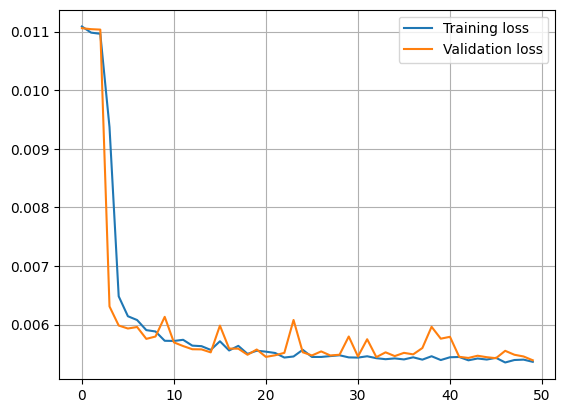

In [208]:
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()
plt.show()

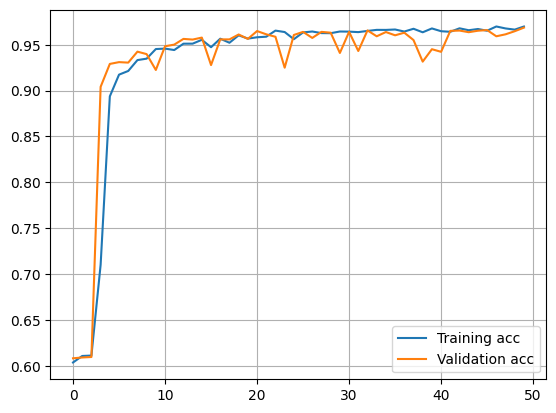

In [209]:
plt.plot(history['train_acc'], label='Training acc')
plt.plot(history['val_acc'], label='Validation acc')
plt.legend()
plt.grid()
plt.show()

## Evaluation

In [221]:
with torch.no_grad():
    predicted = torch.tensor([]).to(default_device)
    Y_true = torch.tensor([]).to(default_device)
    for features, label in valid_loader:
        predicted = torch.concat([predicted, mlp(features.to(default_device))])
        Y_true = torch.concat([Y_true,label.to(default_device)])
    predicted = predicted.argmax(-1)

predicted = predicted.cpu().numpy()
Y_true = Y_true.cpu().numpy()

In [222]:
accuracy = accuracy_score(Y_true, predicted)
precision = precision_score(Y_true, predicted)
recall = recall_score(Y_true, predicted)
f1 = f1_score(Y_true, predicted)
print(f'Accuracy = {accuracy} \nPrecision = {precision} \nf1_Score = {f1} \nRecall = {recall}')

Accuracy = 0.9686274509803922 
Precision = 0.9756748739246515 
f1_Score = 0.9739413680781759 
Recall = 0.9722140112326337


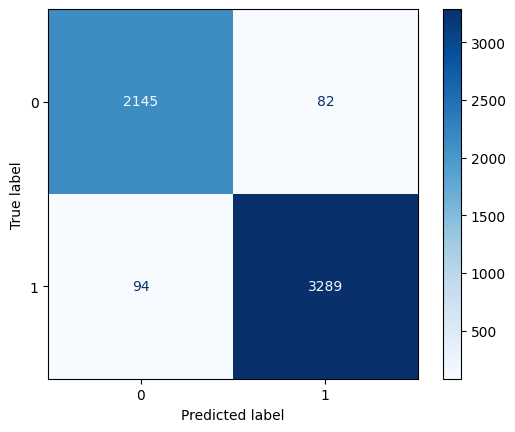

In [234]:
cm = confusion_matrix(Y_true, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## rest